# Create Track Workbook

The process to create a new DeepRacer Track

1. Start with a track.
1. Edit the center-line waypoints (cut, slices, add)
1. Create a smoothed version.
1. Adjust size
1. Export Numpy and SVG versions

In [35]:
import glob
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import textwrap

from deepracer.tracks import TrackIO, Track
from deepracer.logs import \
    PlottingUtils as pu

In [36]:
def chaikins_corner_cutting(coords, refinements=5):
    _coords = np.array(coords)

    for _ in range(refinements):
        L = _coords.repeat(2, axis=0)
        R = np.empty_like(L)
        R[0] = L[0]
        R[2::2] = L[1:-1:2]
        R[1:-1:2] = L[2::2]
        R[-1] = L[-1]
        _coords = L * 0.75 + R * 0.25

    return _coords

In [37]:
def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)                                                
    pu._plot_coords(ax, line)                                                       
    pu._plot_line(ax, line)                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    pu._plot_coords(ax, line)                                                       
    pu._plot_line(ax, line)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    pu._plot_coords(ax, line)                                                       
    pu._plot_line(ax, line)     

## Load the track to work on

In [38]:
# Conveniently list available tracks to analyze
tu = TrackIO(base_path='/home/ludvigse/deepracer-analysis/tracks')

In [39]:
# Replace the name here with the track to analyze
TRACK_NAME = '2022_reinvent_champ'
TARGET_TRACK_NAME = 'Amoeba'
CENTER_LINE_WIDTH = 25
OUTER_LINE_WIDTH = 75
TRACK_WIDTH = 950
SIZE_ADJUST = -50

In [40]:
# Load the track and waypoints
track = tu.load_track(TRACK_NAME)
waypoints = track.waypoints

Loaded 112 waypoints


Is loop/ring?  False
Length: 30.33,8.15,36.25
Width: 0.95


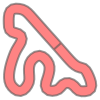

In [41]:
# Convert to Shapely objects
center_line = waypoints[72:-12,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)


road_poly = Polygon(np.vstack((outer_border, np.flipud(inner_border))))
print("Is loop/ring? ", l_center_line.is_ring)
print("Length: {:0.2f},{:0.2f},{:0.2f}".format(l_inner_border.length, l_center_line.length, l_outer_border.length))
print("Width: {:0.2f}".format(l_inner_border.interpolate(0).distance(l_outer_border.interpolate(0))))
road_poly

## Display the original track waypoints

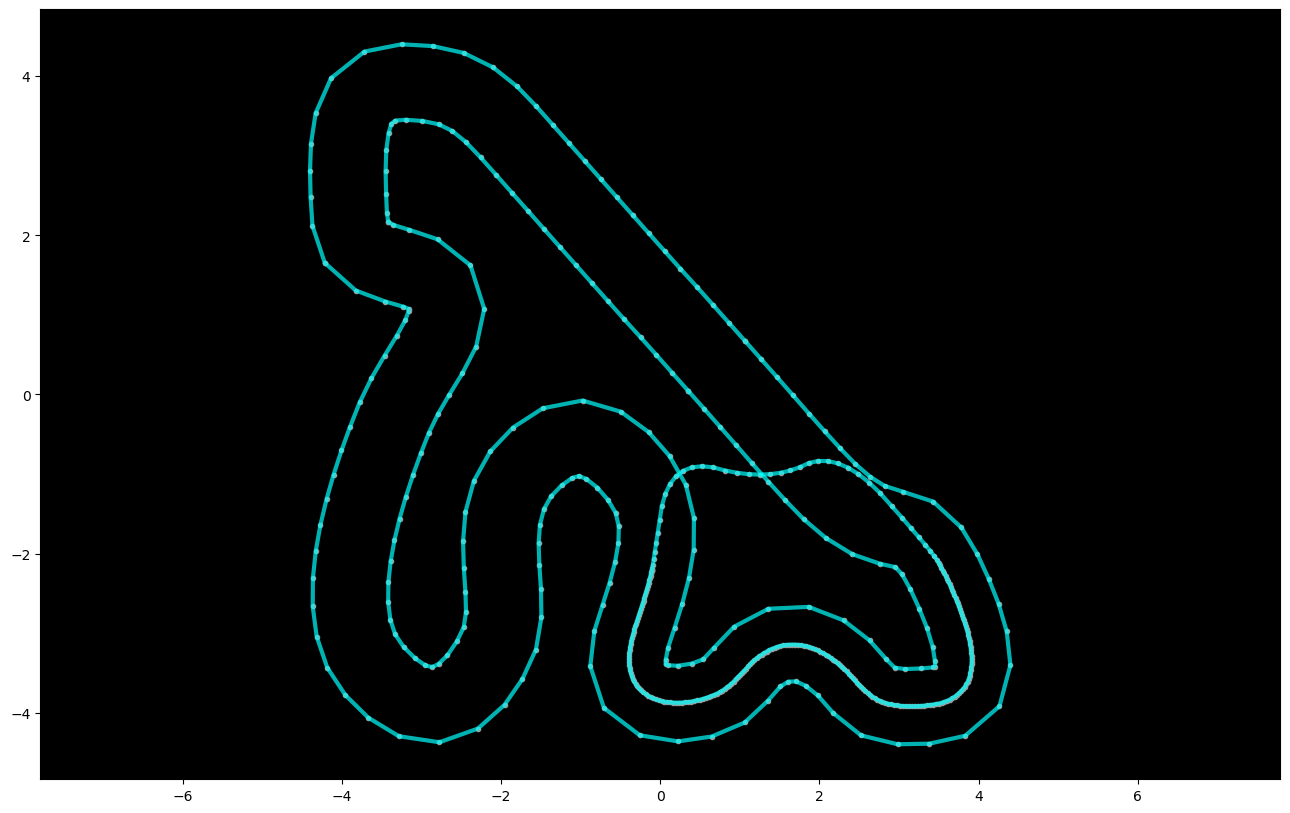

In [42]:
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')

center_line_loop = np.vstack([center_line, outer_border[-7], inner_border[-6], inner_border[68], center_line[0]])
smooth_center = chaikins_corner_cutting(center_line_loop, refinements=3)
print_border(ax, smooth_center, inner_border, outer_border)

## Create new Polygons

In [43]:
# Convert into millimeter (needed for SVG) - reduce size of center-line with 10 cm.
center_polygon_reduced = Polygon(smooth_center*1000).buffer(SIZE_ADJUST)

# Normalize position (x and y) 
x_val = np.array(center_polygon_reduced.exterior.xy[0])
x_moved = x_val - min(x_val) + TRACK_WIDTH/2

y_val = np.array(center_polygon_reduced.exterior.xy[1])
y_moved = y_val - min(y_val) + TRACK_WIDTH/2

# Stack into two-column numpy
smooth_center_moved = np.column_stack((x_moved, y_moved))

In [44]:
# Filled polygon -- exterior is center-line
center_polygon_moved_reduced = Polygon(smooth_center_moved)

# Polygons for outer line (both inner and outer side)
center_polygon_outer = center_polygon_moved_reduced.buffer(TRACK_WIDTH/2, join_style=1)
center_polygon_outer_border = center_polygon_outer.buffer(-OUTER_LINE_WIDTH, join_style=1)

# Polygons for inner line (both inner and outer side)
center_polygon_inner = center_polygon_moved_reduced.buffer(-TRACK_WIDTH/2, join_style=1)
center_polygon_inner_border = center_polygon_inner.buffer(OUTER_LINE_WIDTH, join_style=1)

# Diff polygons for inner line, outer line and the track surface
inner_border_p = center_polygon_inner_border.difference(center_polygon_inner)
outer_border_p = center_polygon_outer.difference(center_polygon_outer_border)
track_p = center_polygon_outer.difference(center_polygon_inner)

# Start line
start_center_point = center_polygon_moved_reduced.exterior.interpolate(0.0, normalized=True)

start_inner_d = center_polygon_inner.exterior.project(start_center_point, normalized=True)
start_inner_p = center_polygon_inner.exterior.interpolate(start_inner_d, normalized=True)

start_outer_d = center_polygon_outer.exterior.project(start_center_point, normalized=True)
start_outer_p = center_polygon_outer.exterior.interpolate(start_outer_d, normalized=True)

start_line_ls = LineString([start_inner_p, start_outer_p])

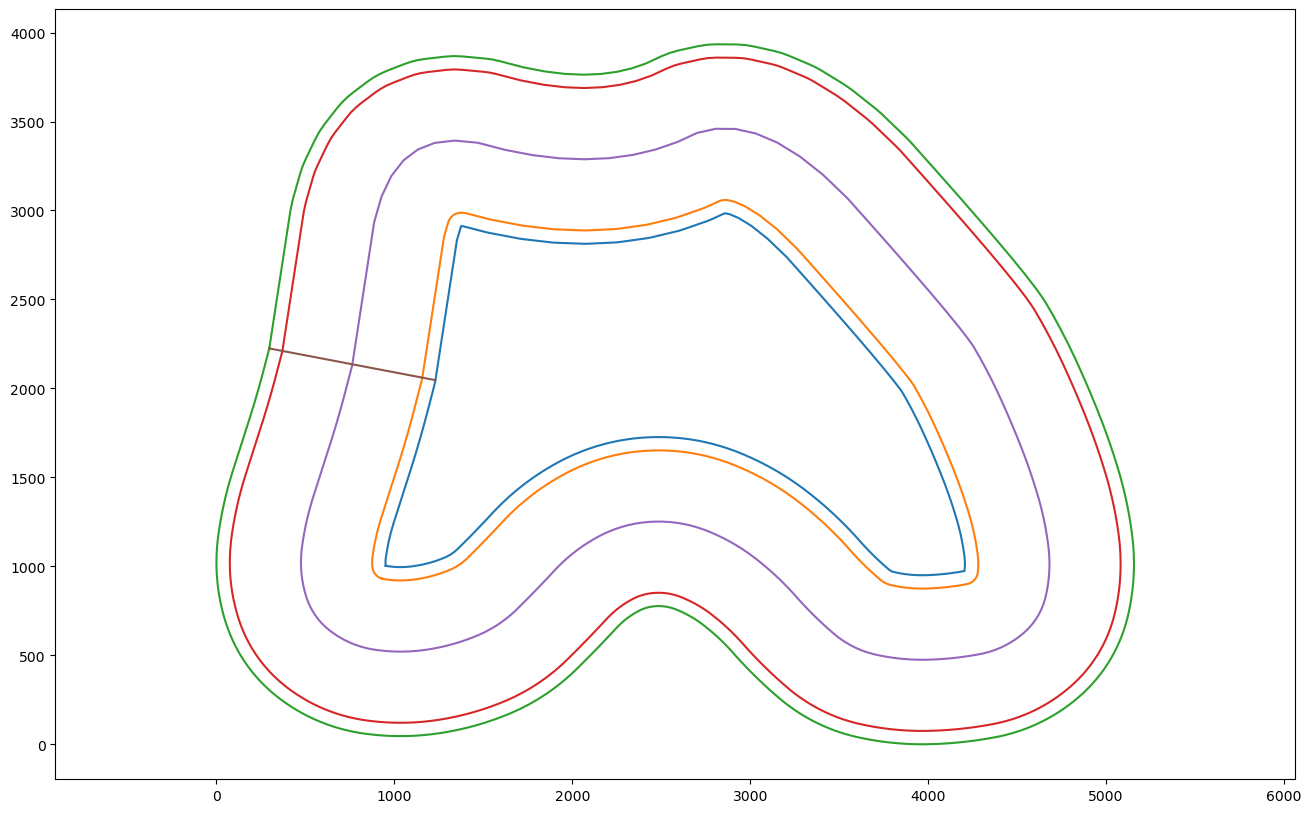

In [45]:
fig = plt.figure(1, figsize=(16, 10))

x_i, y_i = center_polygon_inner.exterior.xy
plt.plot(x_i, y_i)
x_ib, y_ib = center_polygon_inner_border.exterior.xy
plt.plot(x_ib, y_ib)
x_o, y_o = center_polygon_outer.exterior.xy
plt.plot(x_o, y_o)
x_ob, y_ob = center_polygon_outer_border.exterior.xy
plt.plot(x_ob, y_ob)

x, y = center_polygon_moved_reduced.exterior.xy
plt.plot(x,y)

x_s, y_s = start_line_ls.xy
plt.plot(x_s,y_s)

# to net let the image be distorted along the axis
plt.axis('equal')
plt.show()

In [46]:
dim_x = max(x_o)-min(x_o)
dim_y = max(y_o)-min(y_o)
print(f"Track dimensions x:{(dim_x/1000):0.2f}, y:{(dim_y/1000):0.2f}")
print(f"Length: {(center_polygon_outer.exterior.length/1000):0.2f}")

Track dimensions x:5.16, y:3.93
Length: 15.72


## Create waypoints / route for Robomaker

In [47]:
POINTS=100
waypoints_new = np.zeros((POINTS+1,6))
for i in range(0,POINTS):
    p_c = center_polygon_moved_reduced.exterior.interpolate(i/POINTS, normalized=True)
    waypoints_new[i, 0] = p_c.x
    waypoints_new[i, 1] = p_c.y

    d = center_polygon_inner.exterior.project(p_c, normalized=True)
    p = center_polygon_inner.exterior.interpolate(d, normalized=True)
    waypoints_new[i, 2] = p.x
    waypoints_new[i, 3] = p.y

    d = center_polygon_outer.exterior.project(p_c, normalized=True)
    p = center_polygon_outer.exterior.interpolate(d, normalized=True)
    waypoints_new[i, 4] = p.x
    waypoints_new[i, 5] = p.y

waypoints_new[POINTS] = waypoints_new[0]

# Waypoints are in meter (we converted to mm above)
waypoints_new /= 1000.0
np.save(f"../routes/{TARGET_TRACK_NAME}", waypoints_new)

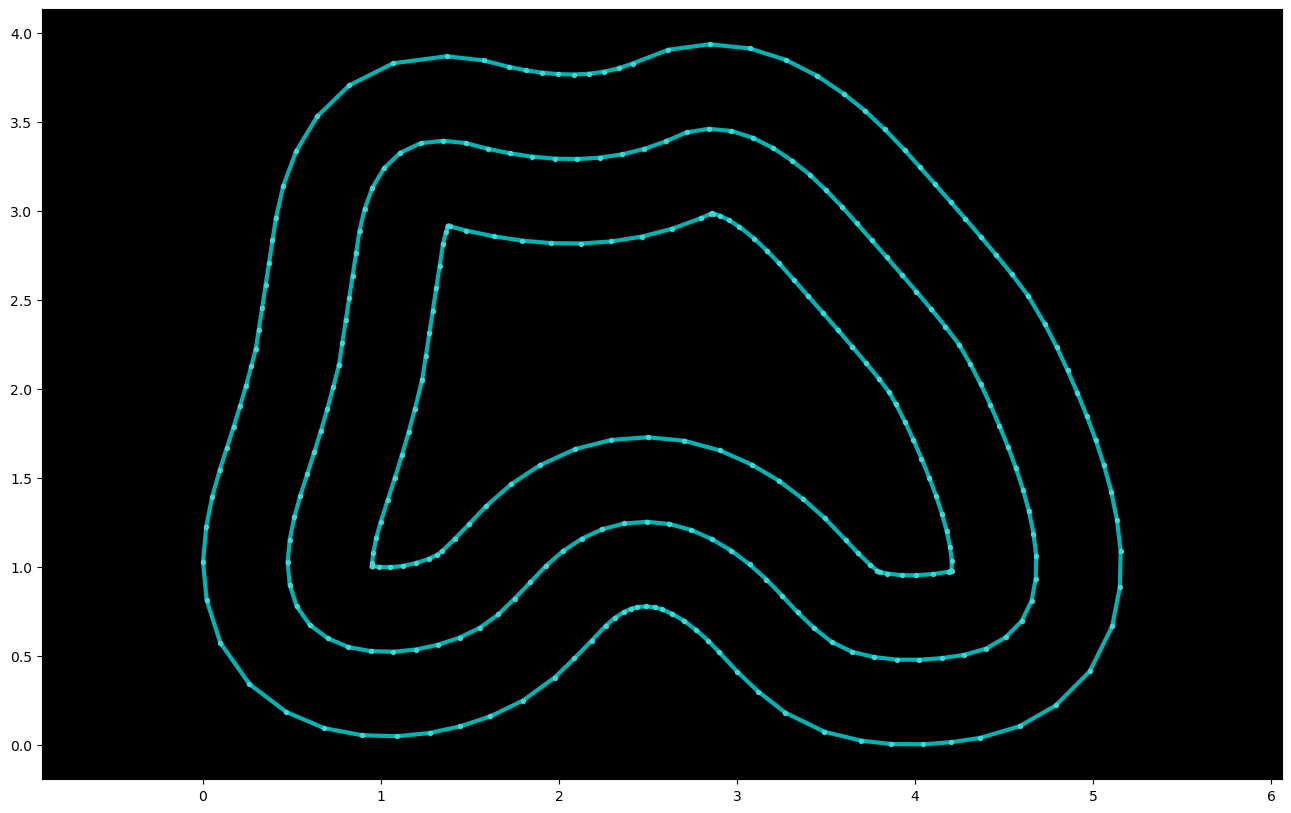

In [48]:
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')

print_border(ax, waypoints_new[:,0:2], waypoints_new[:,2:4], waypoints_new[:,4:6])

In [49]:
import xml.etree.ElementTree as ET

def create_svg(obj: Polygon, id: str, fill_color: str=None, fill_opacity: float=1, border_color: str=None, border_width: int=0, border_style: str=None, border_offset: int=0):
    tree = ET.ElementTree(ET.fromstring(obj.svg()))
    root = tree.getroot() 
    root.set('id', id)
    
    # Strip not-needed attributes
    root.attrib.pop("fill", None)
    root.attrib.pop("fill-rule", None)
    root.attrib.pop("stroke", None)
    root.attrib.pop("stroke-width", None)
    root.attrib.pop("opacity", None)
    
    style = ""
    
    if fill_color is None:
        style += "fill:none;"
    else:
        style += f"fill:{fill_color};"
        style += f"fill-opacity:{fill_opacity};"

    if border_color is None:
        style += "stroke:none;"
    else:
        style += f"stroke:{border_color};"
        style += f"stroke-width:{border_width};"
        style += "stroke-opacity:1;"

        if border_style is not None:
            style += f"stroke-dasharray:{border_style};"
            style += f"stroke-dashoffset:{border_offset};"

    root.set('style', style)
        
#    return ET.tostring(root, encoding='unicode')
    return root

In [50]:
doc_props = {
    'id': TARGET_TRACK_NAME,
    'version': '1.1',
    'baseProfile': 'full',
    'width': '{width:.5f}mm'.format(width = dim_x),
    'height': '{height:.5f}mm'.format(height = dim_y),
    'viewBox': '%.5f,%.5f,%.5f,%.5f' % (0, 0, dim_x, dim_y),
    'xmlns': 'http://www.w3.org/2000/svg',
    'xmlns:ev': 'http://www.w3.org/2001/xml-events',
    'xmlns:xlink': 'http://www.w3.org/1999/xlink',
    'xmlns:sodipodi': 'http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd'
}

view_props = {
    'id': 'trackview',
    'pagecolor': '#00c389',
    'bordercolor': '#000000',
    'borderopacity': '0.25'   
}

with open(f"{TARGET_TRACK_NAME}_raw.svg", 'wb') as f:
    
    svg = ET.Element("svg")
    tree = ET.ElementTree(svg)

    for key in doc_props:
        val = doc_props[key]
        svg.set(key, val)

    view = ET.SubElement(svg, "sodipodi:namedview")
    for key in view_props:
        val = view_props[key]
        view.set(key, val)

    svg.insert(1, create_svg(track_p, "road", fill_color="#232f3e", border_color=None))
    svg.insert(2, create_svg(inner_border_p, "il", fill_color="#ffffff", border_color=None))
    svg.insert(3, create_svg(outer_border_p, "ol", fill_color="#ffffff", border_color=None))
    svg.insert(4, create_svg(center_polygon_moved_reduced, "cl", fill_color=None, border_color="#ff9900", border_width=CENTER_LINE_WIDTH, border_style="50,50"))
    svg.insert(5, create_svg(start_line_ls, "start_line", fill_color=None, border_color="#ffffff", border_width=100, border_style=None))

    tree.write(f, encoding='utf-8', xml_declaration=True)


In [51]:
doc_props = {
    'id': TARGET_TRACK_NAME,
    'version': '1.1',
    'baseProfile': 'full',
    'width': '{width:.5f}mm'.format(width = dim_x),
    'height': '{height:.5f}mm'.format(height = dim_y),
    'viewBox': '%.5f,%.5f,%.5f,%.5f' % (0, 0, dim_x, dim_y),
    'xmlns': 'http://www.w3.org/2000/svg',
    'xmlns:ev': 'http://www.w3.org/2001/xml-events',
    'xmlns:xlink': 'http://www.w3.org/1999/xlink',
    'xmlns:sodipodi': 'http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd'
}

view_props = {
    'id': 'trackview',
    'pagecolor': '#ffffff',
    'bordercolor': '#000000',
    'borderopacity': '0.25',
    'inkscape:pageopacity': '0',
    'inkscape:pagecheckerboard': 'true'
}

with open(f"{TARGET_TRACK_NAME}_iconography.svg", 'wb') as f:
    
    svg = ET.Element("svg")
    tree = ET.ElementTree(svg)

    for key in doc_props:
        val = doc_props[key]
        svg.set(key, val)

    view = ET.SubElement(svg, "sodipodi:namedview")
    for key in view_props:
        val = view_props[key]
        view.set(key, val)

    svg.insert(1, create_svg(track_p, "road", fill_color="#232f3e", fill_opacity=0.7, border_color=None))
    svg.insert(2, create_svg(center_polygon_moved_reduced, "cl", fill_color=None, border_color="#ffffff", border_width=50))

    tree.write(f, encoding='utf-8', xml_declaration=True)
